In [48]:
import os
import tensorflow as tf
import cv2
import csv
import shutil
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from sklearn.model_selection import train_test_split

In [49]:
height = 224
width = 224
imgs = []
blank_image = np.zeros((height,width), np.uint8)

In [50]:
#iris_dataset_preview
data = pd.read_csv('Iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [51]:
#clearing images
def clear_images(image):
    imgs.clear()
    if (os.path.exists('data')):
        shutil.rmtree('data')
    os.mkdir('data')
    os.mkdir('data/train')
    os.mkdir('data/test')
    os.mkdir('data/val')
clear_images(imgs) 

In [52]:
#create single SuperTML image from data
def create_tml_image(data_line):
    font = ImageFont.truetype('Arial.ttf', size = 40)
    tml_img = Image.new('RGB', (width, height), color = 'black')
    draw  = ImageDraw.Draw(tml_img)
    draw.text((36, 36), str(data_line['SepalLengthCm']), font=font, fill = (255, 255, 255))
    draw.text((130, 36), str(data_line['SepalWidthCm']), font=font, fill = (255, 255, 255))
    draw.text((36, 130), str(data_line['PetalWidthCm']), font=font, fill = (255, 255, 255))
    draw.text((130, 130), str(data_line['PetalLengthCm']), font=font, fill = (255, 255, 255))
    img_name = str(data_line['Id']) + '_' + data_line['Species'] + ".jpg"
    tml_img.save(os.path.join('data', img_name))
    imgs.append(img_name)
    img_display = Image.open(os.path.join('data', img_name), 'r')
    plt.imshow(np.asarray(img_display))

In [53]:
#create all SuperTML images for given data located at 'path_to_data'
def create_tml_image_total(path_to_data):
    data = pd.read_csv(path_to_data)
    counter= 0
    font = ImageFont.truetype('Arial.ttf', size = 40)
    for idx in data.index:
        counter+=1
        data_line = data.iloc[idx]
        tml_img = Image.new('RGB', (width, height), color = 'black')
        draw  = ImageDraw.Draw(tml_img)
        draw.text((36, 36), str(data_line['SepalLengthCm']), font=font, fill = (255, 255, 255))
        draw.text((130, 36), str(data_line['SepalWidthCm']), font=font, fill = (255, 255, 255))
        draw.text((36, 130), str(data_line['PetalWidthCm']), font=font, fill = (255, 255, 255))
        draw.text((130, 130), str(data_line['PetalLengthCm']), font=font, fill = (255, 255, 255))
        img_name = str(data_line['Id']) + "_" + data_line['Species'] + ".jpg"
        tml_img.save(os.path.join('data', img_name))
        imgs.append(img_name)
    print(counter)

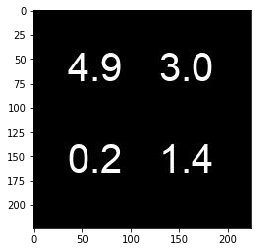

In [54]:
create_tml_image(data.iloc[1])

In [55]:
clear_images(imgs)
create_tml_image_total('Iris.csv')

150


In [56]:
train, test = train_test_split(imgs, test_size=0.2, random_state=1)
#train, val = train_test_split(train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [57]:
print(len(train))
print(len(test))
#print(len(val))

120
30


In [58]:
for image in train:
    if (not os.path.exists(os.path.join('data/train', image))):
        shutil.move(os.path.join('data', image), os.path.join('data', 'train'))
"""for image in val:
    if (not os.path.exists(os.path.join('data/val', image))):
        shutil.move(os.path.join('data', image), os.path.join('data', 'val'))"""
for image in test:
    if (not os.path.exists(os.path.join('data/test', image))):
        shutil.move(os.path.join('data', image), os.path.join('data', 'test'))

In [59]:
#creating labels
def create_label_dict(data):
    labels = {}
    index = 0 
    for idx in data.index:
        if (data.iloc[idx]['Species'] not in labels):
            labels[data.iloc[idx]['Species']] = index
            index+=1
    return labels
labels = create_label_dict(data)

In [60]:
#one-hot encoding of classes of Irises
def to_one_hot(labels, dimensions):
    results = np.zeros((len(labels), dimensions))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results
iris_labels = [0,1,2]
iris_one_hot = to_one_hot(iris_labels, 3)

#get the one-hot matrix of a given 'label'
def get_one_hot_encoding(label, label_dict):
    for key in label_dict:
        if (label==key):
            return iris_one_hot[label_dict[label]]
        
#create dictionary for one-hot encodings of labels
def create_one_hot_dict(one_hot, labels):
    final_dict = {}
    for i in labels:
        if (i not in final_dict):
            final_dict[i]=get_one_hot_encoding(i, labels)
    return final_dict

def get_label(val, one_hot_dict):
    for elem in one_hot_dict:
        comparison = (one_hot_dict[elem]==val)
        if (comparison.all()):
            return elem

In [61]:
one_hot_dict = create_one_hot_dict(get_one_hot_encoding('Iris-versicolor', labels), labels)
get_label(one_hot_dict['Iris-setosa'], one_hot_dict)
print(get_label(one_hot_dict['Iris-setosa'], one_hot_dict))

Iris-setosa


In [158]:
print(one_hot_dict['Iris-versicolor'])

[0. 1. 0.]


In [62]:
#creating images and label pairs
def create_labels(train, test):
    #val_labels = []
    test_labels = []
    train_labels = []
    #val_examples = []
    test_examples = []
    train_examples = []
    for image in train:
        label = image.split('_')[1][:(int(len(image.split('_')[1])-4))]
        vect = get_one_hot_encoding(label, labels)
        train_labels.append(vect)
        train_examples.append(mpimg.imread('data/train/' + image))
    for image in test:
        label = image.split('_')[1][:(int(len(image.split('_')[1])-4))]
        test_labels.append(get_one_hot_encoding(label, labels))
        test_examples.append(mpimg.imread('data/test/' + image))
    """for image in val:
        label = image.split('_')[1][:(int(len(image.split('_')[1])-4))]
        val_labels.append(get_one_hot_encoding(label, labels))
        val_examples.append(mpimg.imread('data/val/' + image))"""
    return test_labels, train_labels, test_examples, train_examples
    #return val_labels, test_labels, train_labels, val_examples, test_examples, train_examples
#val_labels, test_labels, train_labels, val_examples, test_examples, train_examples = create_labels(train, test, val)
test_labels, train_labels, test_examples, train_examples = create_labels(train, test)

In [63]:
def get_label_name(val):
    for vect in range(iris_one_hot.shape[1]):
        if val==iris_one_hot[:,vect]:
            return labels.get_key(vect)

<TensorSliceDataset shapes: ((224, 224, 3), (3,)), types: (tf.int32, tf.float64)>
<TensorSliceDataset shapes: ((224, 224, 3), (3,)), types: (tf.int32, tf.float64)>


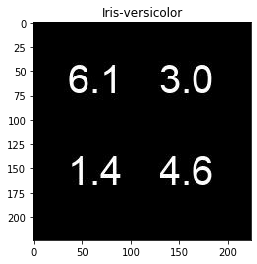

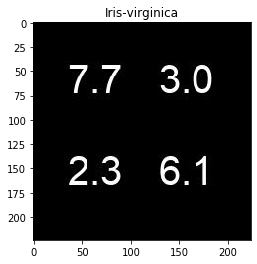

In [64]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))
#val_dataset = tf.data.Dataset.from_tensor_slices((val_examples, val_labels))
print(train_dataset)
print(test_dataset)
#print(val_dataset)

for image, label in train_dataset.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label(np.asarray(label), one_hot_dict))

In [65]:
IMG_SIZE = 160 # All images will be resized to 160x160
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label
train = train_dataset
#validation = val_dataset.map(format_example)
test = test_dataset

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float64)


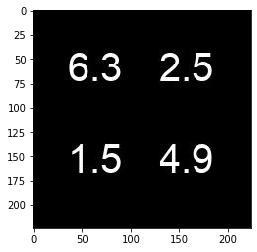

In [159]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE)
train_batches = train_batches.batch(BATCH_SIZE)
#validation_batches = validation.shuffle(SHUFFLE_BUFFER_SIZE)
#validation_batches = validation_batches.batch(BATCH_SIZE)
test_batches = test.shuffle(SHUFFLE_BUFFER_SIZE)
test_batches = test_batches.batch(BATCH_SIZE)
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape
image_test = plt.imshow(image_batch[0])
print(label_batch[0])

In [160]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

In [161]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 7, 7, 2048)


In [162]:
#BEGIN
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [163]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 2048)


In [167]:
dense_layer = tf.keras.layers.Dense(64, input_shape=(20, 1280))
dense = dense_layer(feature_batch_average)
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(dense)#prediction_batch = prediction_layer(dense)
print(prediction_batch.shape)

(10, 3)


In [168]:
model = tf.keras.Sequential([base_model, global_average_layer, dense_layer, prediction_layer])

In [169]:
base_learning_rate = 0.001
model.compile(optimizer=tf.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0,
                                                           name='categorical_crossentropy'
                                                          ),
              metrics=[tf.metrics.CategoricalAccuracy(name='accuracy')])

In [170]:
model.summary()
len(model.trainable_variables)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 195       
Total params: 23,719,043
Trainable params: 131,331
Non-trainable params: 23,587,712
_________________________________________________________________


4

In [171]:
initial_epochs = 10
#validation_steps= 4

#loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [172]:
"""print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))"""

'print("initial loss: {:.2f}".format(loss0))\nprint("initial accuracy: {:.2f}".format(accuracy0))'

In [173]:
history = model.fit(train_batches, epochs=initial_epochs)

Epoch 1/10
12/12 [==============================] - 5s 438ms/step - loss: 2.2777 - accuracy: 0.3417
Epoch 2/10
12/12 [==============================] - 6s 465ms/step - loss: 1.3390 - accuracy: 0.4250
Epoch 3/10
12/12 [==============================] - 6s 471ms/step - loss: 1.0705 - accuracy: 0.5167
Epoch 4/10
12/12 [==============================] - 6s 471ms/step - loss: 1.2460 - accuracy: 0.4833
Epoch 5/10
12/12 [==============================] - 6s 485ms/step - loss: 0.7781 - accuracy: 0.7000
Epoch 6/10
12/12 [==============================] - 6s 491ms/step - loss: 0.8740 - accuracy: 0.6333
Epoch 7/10
12/12 [==============================] - 6s 495ms/step - loss: 0.6676 - accuracy: 0.7083
Epoch 8/10
12/12 [==============================] - 6s 503ms/step - loss: 0.7828 - accuracy: 0.6583
Epoch 9/10
12/12 [==============================] - 6s 506ms/step - loss: 0.4613 - accuracy: 0.8250
Epoch 10/10
12/12 [==============================] - 6s 496ms/step - loss: 0.6722 - accuracy: 0.7167

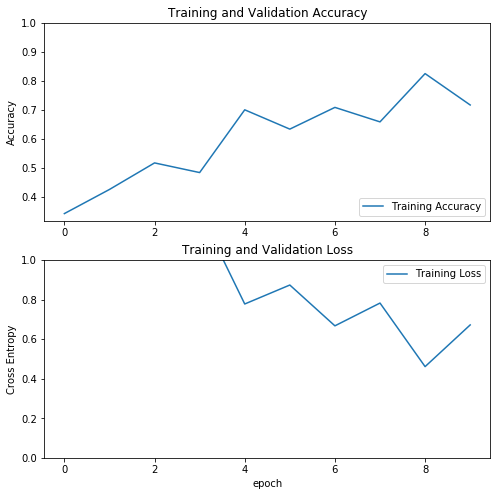

In [174]:
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [175]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  175


In [176]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0,
                                                           name='categorical_crossentropy'),
              optimizer = tf.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=[tf.metrics.CategoricalAccuracy(name='accuracy')])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 195       
Total params: 23,719,043
Trainable params: 19,584,259
Non-trainable params: 4,134,784
_________________________________________________________________


In [177]:
len(model.trainable_variables)

94

In [178]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1])

Epoch 10/30
12/12 [==============================] - 12s 1s/step - loss: 1.7746 - accuracy: 0.7750
Epoch 11/30
12/12 [==============================] - 13s 1s/step - loss: 0.4214 - accuracy: 0.9000
Epoch 12/30
12/12 [==============================] - 13s 1s/step - loss: 0.4041 - accuracy: 0.8917
Epoch 13/30
12/12 [==============================] - 12s 1s/step - loss: 0.3359 - accuracy: 0.9333
Epoch 14/30
12/12 [==============================] - 13s 1s/step - loss: 0.1578 - accuracy: 0.9667
Epoch 15/30
12/12 [==============================] - 12s 1s/step - loss: 0.4672 - accuracy: 0.9083
Epoch 16/30
12/12 [==============================] - 13s 1s/step - loss: 0.0878 - accuracy: 0.9833
Epoch 17/30
12/12 [==============================] - 12s 1s/step - loss: 0.0048 - accuracy: 1.0000
Epoch 18/30
12/12 [==============================] - 13s 1s/step - loss: 0.0020 - accuracy: 1.0000
Epoch 19/30
12/12 [==============================] - 12s 1s/step - loss: 0.0606 - accuracy: 0.9667
Epoch 20/3

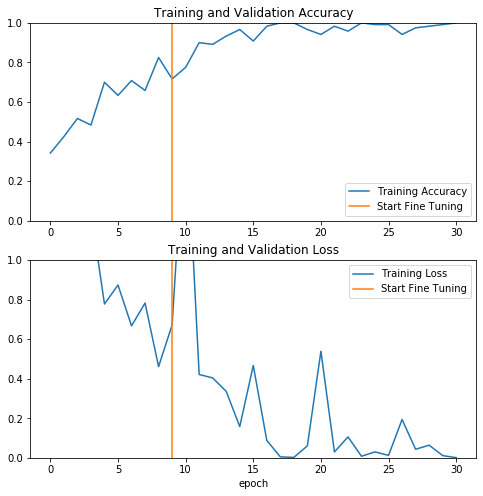

In [179]:
acc += history_fine.history['accuracy']
#val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
#val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [191]:
print("Evaluate on test data")
results = model.evaluate(test_batches)
print("test loss, test acc:", results)

Evaluate on test data
3/3 [==============================] - 1s 308ms/step - loss: 4.1437 - accuracy: 0.9667
test loss, test acc: [4.143747806549072, 0.9666666388511658]


In [202]:
for image_batch_test, label_batch_test in test_batches.take(1):
    pass
print(label_batch_test.shape)
predictions = model.predict(image_batch_test)
print(predictions)
print(label_batch_test)

(10, 3)
[[  -2.8288627   -51.20636      69.20524   ]
 [  67.021545   -123.716965      8.277323  ]
 [ -13.498721     24.367376     -1.4143889 ]
 [  30.621796    -56.064606      3.3748887 ]
 [  -6.6901536   -19.10546      27.73491   ]
 [ -25.880238     41.04498       3.9862297 ]
 [  59.288      -109.388794      6.658596  ]
 [  55.60429     -95.23222      -0.37978947]
 [  -4.8407087   -73.477264     88.4704    ]
 [  34.695805    -59.982258      0.7823882 ]]
tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]], shape=(10, 3), dtype=float64)


In [187]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_batches)
print("test loss, test acc:", results)

Evaluate on test data
3/3 [==============================] - 1s 315ms/step - loss: 4.1437 - accuracy: 0.9667
test loss, test acc: [4.143747806549072, 0.9666666388511658]
